In [1]:
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers.experimental.preprocessing import Normalization
from keras import initializers
from keras import metrics
import matplotlib.pyplot as mpl
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras import backend as K

In [2]:
#Get the current working directory
cwd = os.getcwd()
print(cwd)

C:\Users\kayde\OneDrive\Desktop\mannada\RainfallData


In [3]:
#the variables as recorded by the station
variables = [
        'dswr',
        'lftx',
        'mslp',
        'p__f',
        'p__u',
        'p__v',
        'p__z',
        'p_th',
        'p_zh',
        'p5_f',
        'p5_u',
        'p5_v',
        'p5_z',
        'p5th',
        'p5zh',
        'p8_f',
        'p8_u',
        'p8_v',
        'p8_z',
        'p8th',
        'p8zh',
        'p500',
        'p850',
        'pottmp',
        'pr_wtr',
        'prec',
        'r500',
        'r850',
        'rhum',
        'shum',
        'temp',
]

#The three regions
regions = [
        '82.5', #A
        '85.0', #B
        '87.5', #C
]

'''
TAKING IN ALL THE X VARIABLES
'''

#define an empty dictionary
boxes = {}

#iterating over regions
for region in regions:
    
    df_li = pd.DataFrame() # empty dataframe
    
    #iterating over variables
    for var in variables:
        
        path = os.path.join(cwd,"DATA\\BOX_20N_%sE\\ncep_%s.dat"%(region,var)) # Cleverly curated path for automation
        
        with open(path) as file: #open the respected variable file for the region
            
            temp = file.read().splitlines()
            temp = [float(i) for i in temp]
            
        df_li[region + '_' + var] = temp #and for every variable, store that data under header: <coordinate_variable>
        
    boxes[region]=df_li #and assign that dataframe for every region
    
'''
TAKING IN ALL THE Y VALUES
'''

rain = []

for i in range(5): # iterate from 0 to 4 i.e. 5 times
    
    path = os.path.join(cwd,"DATA\\rain%d.dat"%(i+1)) # join cwd to path of rain data
    
    with open(path) as file:
        
        lines = file.read().splitlines()
        lines = [float(i) for i in lines]
        rain.append( lines )  #store in rain list

In [4]:
#time for some data refining and model training

#Trimming BOXES, this is to match with the rain data, day-by-day
for region in regions:
    boxes[region] = boxes[region].iloc[4749:,] # removing 4749 rows from front
    boxes[region] = boxes[region].iloc[:10957,] # keeping only 10957 of the rest

#sample take BOX A and PLACE 1
df = boxes['82.5']
rain1 = rain[0]

In [5]:
class predictionModel:
    '''
    This is a class defining the Prediction Neural Network, Its input filtering,
    '''
    def __init__(self,X,Y,classStr,layer1_node=31,layer2_node=31):
        self.__cStr = classStr
        self.__layer1_node = layer1_node
        self.__layer2_node = layer2_node
        self.__xdata = X
        self.__ydata = Y
        self.__inpdim = len(X[0])
        self.__class = classStr
        self.__trained = False
        if classStr == 'regression':
            self.__model = self.__neuralNetworkRegressor()
        elif classStr == 'classification':
            self.__model = self.__neuralNetworkClassifier()
        else:
            print('\nError: model %s not found'%(classStr))
    def R2Coefficient(self,y_true, y_pred):
        SS_res =  K.sum( K.square( y_true - y_pred ) ) 
        SS_tot = K.sum( K.square( y_true - K.mean( y_true ) ) ) 
        return ( 1 - SS_res/( SS_tot + K.epsilon() ) )
    
    def __neuralNetworkRegressor(self):
        model = Sequential(
            [
                Dense(
                    self.__layer1_node,
                    input_dim=self.__inpdim,
                    activation='relu',
                    kernel_initializer=initializers.GlorotNormal(seed=None),
                    bias_initializer='zeros',
                ),
                Dense(
                    self.__layer2_node,
                    activation='sigmoid',
                    kernel_initializer=initializers.HeNormal(seed=None),
                    bias_initializer='zeros',
                ),
                Dense(
                    1,
                    activation='relu',
                    kernel_initializer='normal',
                    bias_initializer='zeros',
                ),
            ]
        )
        model.compile(loss='mean_squared_error',optimizer='adam',metrics=[self.R2Coefficient])
        return model
    
    def __neuralNetworkClassifier(self):
        
        model = Sequential(
            [
                Dense(
                    self.__layer1_node,
                    input_dim = self.__inpdim,
                    kernel_initializer=initializers.HeNormal(seed=None), #He Normal goes good with relu
                    bias_initializer='zeros',
                ),
                Dense(
                    self.__layer2_node, 
                    kernel_initializer=initializers.HeNormal(seed=None), #He Normal goes good with relu
                    bias_initializer='zeros',
                ),
                Dense(
                    1,
                    activation='sigmoid', # heard its the best activation for classfication output
                    kernel_initializer='normal',
                    bias_initializer='zeros',
                ),
            ]
        )
        model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
        return model
    
    def trainNetwork(self, epoch = 10, batch = 5):
        xtrain, xtest, ytrain, ytest = train_test_split(self.__xdata,self.__ydata,test_size=0.2)#splitting test-train
        print("Initiating Training Sequence\n")
        history = self.__model.fit(
            xtrain,
            ytrain,
            epochs = epoch,
            batch_size = batch,
        )
        print("\n\nInitiating Testing Sequence\n")
        metrics = self.__model.evaluate(
            xtest,
            ytest,
            batch_size = 5,
        )
        self.__trained = True
        
    def evaluateNetwork(self):
        '''
        This Function isn't really working now,
        Will come back later
        '''
        if self.__trained == False:
            print("ERROR: Model Not Trained")
            return
        print("\nInitiating Evaluation Sequence\n")
        evaluators=[
            ('standardize',StandardScaler()),
            ('mlp',KerasRegressor(
                build_fn =  self.__neuralNetwork(self.__K1,self.__K2),
                epochs = 10,
                batch_size = 5,
                verbose = 0,
            )),
        ]
        pipeline = Pipeline(evaluators)
        results = cross_val_score(
            pipeline,
            self.__xdata,
            self.__ydata,
            cv = KFold(n_splits=10)
        )
        print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))
        
    def predictData(self,X):
        if self.__trained == False:
            inp = input("ERROR: Model Not Trained, Want to train now? (Y/N)");
            if inp == 'N':
                return
            elif inp == 'Y':
                self.trainNetwork()
        Y = self.__model.predict(X);
        return Y
    def plotData(self,X,yreal,ypred=None,pltstr='r.'):
        if ypred.any() == None:
            ypred = self.predictData(X)
        if self.__trained == False:
            inp = input("ERROR: Model Not Trained, Want to train now? (Y/N)");
            if inp == 'N':
                return
            elif inp == 'Y':
                self.trainNetwork()
        '''
        X and Y are evaluation datasets
        pltStr is the plot type as put in matplotlib
        '''
        
        realmax = max(yreal)
        predmax = max(ypred)
        lgt = min(predmax,realmax)+10
        x = np.linspace(0, lgt, 100)
        mpl.rcParams["figure.figsize"] = [10, 10]
        mpl.plot(yreal,ypred,pltstr)
        mpl.plot(x,x,label="convergence")
        mpl.xlabel("Actual Rain Level")
        mpl.ylabel("Predicted Rain Level")
        leg = mpl.legend(loc='upper center')
        mpl.show()
        return
        

In [99]:
ydata_3 = rain1.copy()
for i in range(len(ydata_3)):
    if ydata_3[i] > 2.5:
        ydata_3[i] = 1;
    else:
        ydata_3[i] = 0;
xdata_3 = df.values.tolist()
rainFallPredictor3 = predictionModel(xdata_3,ydata_3,'classification',31,10)
rainFallPredictor3.trainNetwork(5)

Initiating Training Sequence

Epoch 1/5
1753/1753 [==============================] - 2s 1ms/step - loss: 0.3689 - accuracy: 0.8366
Epoch 2/5
1753/1753 [==============================] - 3s 2ms/step - loss: 0.3112 - accuracy: 0.8622
Epoch 3/5
1753/1753 [==============================] - 3s 2ms/step - loss: 0.3069 - accuracy: 0.8623
Epoch 4/5
1753/1753 [==============================] - 2s 1ms/step - loss: 0.3027 - accuracy: 0.8650
Epoch 5/5
1753/1753 [==============================] - 2s 1ms/step - loss: 0.3006 - accuracy: 0.8639


Initiating Testing Sequence

439/439 [==============================] - 1s 1ms/step - loss: 0.2933 - accuracy: 0.8682


Initiating Training Sequence

Epoch 1/10
326/326 [==============================] - 0s 2ms/step - loss: 386.6453 - R2Coefficient: -2.5826
Epoch 2/10
326/326 [==============================] - 0s 1ms/step - loss: 318.9836 - R2Coefficient: -1.3587
Epoch 3/10
326/326 [==============================] - 0s 1ms/step - loss: 274.3062 - R2Coefficient: -0.7168
Epoch 4/10
326/326 [==============================] - 0s 1ms/step - loss: 247.9868 - R2Coefficient: -0.6206: 0s - loss: 253.3118 - R2Coefficient:
Epoch 5/10
326/326 [==============================] - 0s 1ms/step - loss: 232.2062 - R2Coefficient: -1.2284
Epoch 6/10
326/326 [==============================] - 0s 1ms/step - loss: 223.7930 - R2Coefficient: -2.2248
Epoch 7/10
326/326 [==============================] - 1s 2ms/step - loss: 217.5202 - R2Coefficient: -1.6302
Epoch 8/10
326/326 [==============================] - 0s 1ms/step - loss: 214.8147 - R2Coefficient: -1.5516
Epoch 9/10
326/326 [==============================] - 0s 1ms/step - 

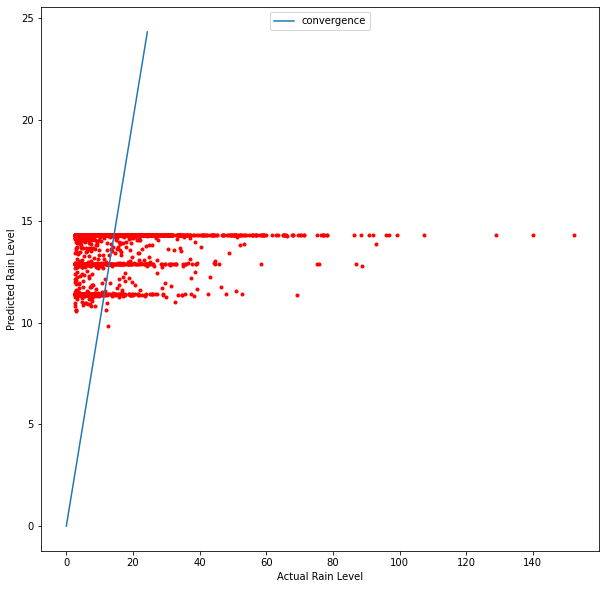

In [126]:
#make a copy of dataframe for use
df_2 = df.copy() 
df_2['rain'] = rain1 #copy y to the dataframe
df_2.drop(df_2[df_2['rain'] <= 2.5].index, inplace = True) #omit all data where y 

ydata_2 = df_2['rain'].values.tolist()

df_2 = df_2.drop(['rain'],axis=1)
xdata_2=df_2.values.tolist()

rainFallPredictor2 = predictionModel(xdata_2,ydata_2,'regression',31,10)

rainFallPredictor2.trainNetwork(10,5)

y_regr = rainFallPredictor2.predictData(xdata_2)

rainFallPredictor2.plotData(xdata_2,ydata_2,y_regr)

Initiating Training Sequence

Epoch 1/10
1753/1753 [==============================] - 3s 2ms/step - loss: 74.7470 - R2Coefficient: -6071424.5000
Epoch 2/10
1753/1753 [==============================] - 3s 2ms/step - loss: 74.6636 - R2Coefficient: -6731880.5000
Epoch 3/10
1753/1753 [==============================] - 3s 2ms/step - loss: 74.5950 - R2Coefficient: -5566703.5000
Epoch 4/10
1753/1753 [==============================] - 3s 2ms/step - loss: 74.5976 - R2Coefficient: -5635780.0000A: 
Epoch 5/10
1753/1753 [==============================] - 3s 2ms/step - loss: 74.6006 - R2Coefficient: -5642045.5000
Epoch 6/10
1753/1753 [==============================] - 3s 2ms/step - loss: 74.6124 - R2Coefficient: -5440256.5000
Epoch 7/10
1753/1753 [==============================] - 3s 2ms/step - loss: 74.5935 - R2Coefficient: -5639869.5000
Epoch 8/10
1753/1753 [==============================] - 3s 2ms/step - loss: 74.5824 - R2Coefficient: -5497116.5000A: 1s - loss: 78.0318 - 
Epoch 9/10
1753/1753 [=

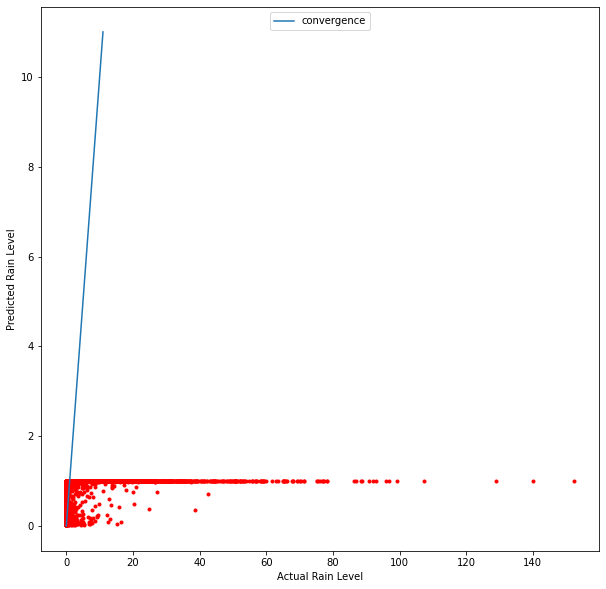

In [119]:
ydat = rain1.copy()
xdat = df.values.tolist()
rainFallPredictor = predictionModel(xdat,ydat,'regression',62,25)
rainFallPredictor.trainNetwork()
yres = rainFallPredictor.predictData(xdat)
rainFallPredictor.plotData(xdat,ydat,yres)